### About the data

Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. The original hand gesture image data represented multiple users repeating the gesture against different backgrounds.

The Sign Language MNIST data came from greatly extending the small number (1704) of the color images included as not cropped around the hand region of interest. To create new data, an image pipeline was used based on ImageMagick and included cropping to hands-only, gray-scaling, resizing, and then creating at least 50+ variations to enlarge the quantity. The modification and expansion strategy was filters ('Mitchell', 'Robidoux', 'Catrom', 'Spline', 'Hermite'), along with 5% random pixelation, +/- 15% brightness/contrast, and finally 3 degrees rotation. Because of the tiny size of the images, these modifications effectively alter the resolution and class separation in interesting, controllable ways.

In [ ]:
# connecting drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

# Loadig Dataset

In [ ]:
# loading the datasets
df = pd.read_csv("/content/gdrive/MyDrive/AI/sign_mnist_train.csv")
df_test = pd.read_csv("/content/gdrive/MyDrive/AI/sign_mnist_test.csv")

In [ ]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
df_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [ ]:
# checking unique values
# each unoque value respresent one letter in the alphabet
# exaple: 0 -> A
df['label'].unique()

array([ 3,  6,  2, 13, 16,  8, 22, 18, 10, 20, 17, 19, 21, 23, 24,  1, 12,
       11, 15,  4,  0,  5,  7, 14])

In [ ]:
# getting information on the dataset
# in total there are 27455 entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


In [ ]:
# checking for null values
df.isna().sum().sum()

0

# Visualization

In [ ]:
# creating dictionary of the labels and respective letters
# it will help to identify if we correctly show label and its respective image
alph_dict = {
  0: 'A',
  1: 'B',
  2: 'C',
  3: 'D',
  4: 'E',
  5: 'F',
  6: 'G',
  7: 'H',
  8: 'I',
  9: 'J',
  10: 'K',
  11: 'L',
  12: 'M',
  13: 'N',
  14: 'O',
  15: 'P',
  16: 'Q',
  17: 'R',
  18: 'S',
  19: 'T',
  20: 'U',
  21: 'V',
  22: 'W',
  23: 'X',
  24: 'Y',
  25: 'Z'
  }

In [ ]:
# reshaping the image data to 28x28 and plotting it
def plot_sign(row_num):
  first_image = df.iloc[row_num, 1:].values.reshape(28, 28)
  plt.figure(figsize = (1.5,2))
  plt.imshow(first_image, cmap='gray')
  plt.title(f"Label: {alph_dict[df.iloc[row_num, 0]]}")
  plt.axis('off')
  plt.show()

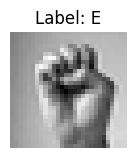

In [ ]:
plot_sign(98)

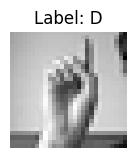

In [ ]:
plot_sign(8)

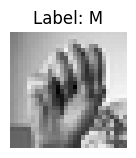

In [ ]:
plot_sign(31)

#Data processing

In [ ]:
# assigning and reshaping train and test data
X = df.drop('label', axis=1).values
X = X.reshape(-1, 1, 28, 28).astype('float32')
y = df['label'].values

X_test = df_test.drop('label', axis=1).values
X_test = X_test.reshape(-1, 1, 28, 28).astype('float32')
y_test = df_test['label'].values

In [ ]:
# normalizing the images
X /= 255.0
X_test /= 255.0

In [ ]:
# splitting into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# converting to PyTorch tensors
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [ ]:
# creating data loaders to feed into the model
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

# CNN Model

In [ ]:
# defining the CNN Model
class SignLanguageCNN(nn.Module):
    def __init__(self):
        super(SignLanguageCNN, self).__init__()
        # first conv layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # second conv layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # fully connected layers
        # first fully connected layer
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        # second fully connected layer
        self.fc2 = nn.Linear(256, 25)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # first conv layer followed by ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # first conv layer followed by ReLU activation and max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # reshaping the tensor for the fully connected layers
        x = x.view(-1, 64 * 7 * 7)
        # first fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))
        # applying dropout for regularization
        x = self.dropout(x)
        # second fully connected layer for final predictions
        x = self.fc2(x)

        return x

In [ ]:
# initializing the model
model = SignLanguageCNN()

In [ ]:
# for faster computation
device= torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)

SignLanguageCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=25, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
# defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Training the model
num_epochs = 20
train_losses, val_losses = [], []

# Loop through the 10 epochs
for epoch in range(num_epochs):
    running_loss = 0.0

    # train loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        outputs = model(images)
        # calculating the loss
        loss = criterion(outputs, labels)
        #backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # calculating and storing the average training loss for the current epoch
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)


    # Validation loop
    val_running_loss = 0.0
    # disabling gradient computation during validation
    with torch.no_grad():
       # iterating through validation data
        total = 0
        correct = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # calculating validation loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_running_loss += loss.item()

    # calculating and storing the average validation loss for the current epoch
    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%')

Epoch [1/20], Loss: 2.5845, Accuracy: 24.13%
Epoch [2/20], Loss: 1.4198, Accuracy: 46.37%
Epoch [3/20], Loss: 1.1630, Accuracy: 60.06%
Epoch [4/20], Loss: 1.1906, Accuracy: 68.11%
Epoch [5/20], Loss: 0.8697, Accuracy: 74.45%
Epoch [6/20], Loss: 0.8935, Accuracy: 77.00%
Epoch [7/20], Loss: 0.3492, Accuracy: 80.17%
Epoch [8/20], Loss: 0.5653, Accuracy: 83.35%
Epoch [9/20], Loss: 0.4013, Accuracy: 84.79%
Epoch [10/20], Loss: 0.4540, Accuracy: 86.80%
Epoch [11/20], Loss: 0.2718, Accuracy: 88.75%
Epoch [12/20], Loss: 0.4649, Accuracy: 91.19%
Epoch [13/20], Loss: 0.2936, Accuracy: 91.60%
Epoch [14/20], Loss: 0.3444, Accuracy: 92.13%
Epoch [15/20], Loss: 0.0589, Accuracy: 93.28%
Epoch [16/20], Loss: 0.2185, Accuracy: 93.81%
Epoch [17/20], Loss: 0.1469, Accuracy: 94.45%
Epoch [18/20], Loss: 0.0483, Accuracy: 95.16%
Epoch [19/20], Loss: 0.0541, Accuracy: 95.68%
Epoch [20/20], Loss: 0.0949, Accuracy: 95.61%


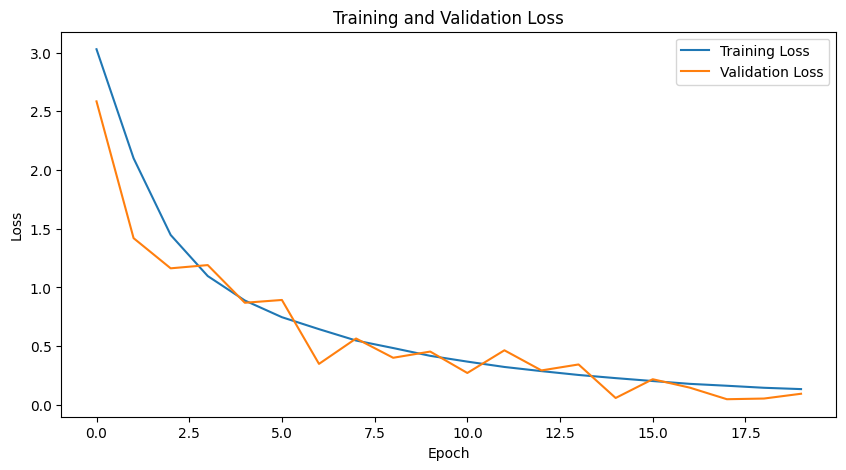

In [ ]:
# plotting the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Testing

In [ ]:
# setting the model to evaluation mode
model.eval()
total_test = 0
correct_test = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels= images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

# calculating testing accuracy
test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 90.92%


In [ ]:
# to test how model works on new data (not test data), we are loading our own images and trying to see of the model correctly predicts the ASl

# laoding an image, converting it to grayscale, and preprocessesing it.
def load_image(image_path):
    transform = transforms.Compose([
        # converting to grayscale
        transforms.Grayscale(num_output_channels=1),
        # resizing to match the model input
        transforms.Resize((28, 28)),
        # converting to tensor
        transforms.ToTensor(),
        # normalizing
        transforms.Normalize((0.5,), (0.5,))
    ])

    image = Image.open(image_path)
    image = transform(image)
    # adding batch dimension
    image = image.unsqueeze(0)
    return image

In [ ]:
# Predicts the class of an image using the provided model.
def predict(model, image):
    model.eval()
    with torch.no_grad():
        image= image.to(device)
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        return predicted.item()

In [ ]:
# def plot_image(image):
#   plt.figure(figsize=(1.5, 2))
#   plt.imshow(image)
#   plt.axis('off')  # Turn off axis labels
#   plt.show()

# funtion to plot images that we took
def plot_image(image,label):
  image = np.squeeze(image)
  plt.figure(figsize = (1.5,3))
  plt.imshow(image, cmap='gray')
  plt.title(f"Label: {label}")
  plt.axis('off')
  plt.show()

Predicted class: D


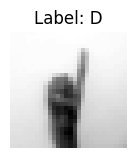

In [ ]:
# Example usage
image_path = '/content/gdrive/MyDrive/AI/asl_imgs/D.jpeg'
image = load_image(image_path)
# converting PIL image to NumPy array
image_array = np.array(image)
# squeezing singleton dimensions if present
image_array = np.squeeze(image_array)
prediction = predict(model, image)
print(f'Predicted class: {alph_dict[prediction]}')
plot_image(image,alph_dict[prediction] )

Predicted class: F


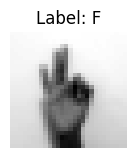

In [ ]:
# Example usage
image_path = '/content/gdrive/MyDrive/AI/asl_imgs/F.jpeg'
image = load_image(image_path)
# converting PIL image to NumPy array
image_array = np.array(image)
# squeezing singleton dimensions if present
image_array = np.squeeze(image_array)
prediction = predict(model, image)
print(f'Predicted class: {alph_dict[prediction]}')
plot_image(image,alph_dict[prediction] )

Predicted class: L


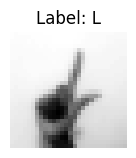

In [ ]:
# Example usage
image_path = '/content/gdrive/MyDrive/AI/asl_imgs/L.jpeg'
image = load_image(image_path)
# converting PIL image to NumPy array
image_array = np.array(image)
# squeezing singleton dimensions if present
image_array = np.squeeze(image_array)
prediction = predict(model, image)
print(f'Predicted class: {alph_dict[prediction]}')
plot_image(image,alph_dict[prediction] )

Predicted class: N


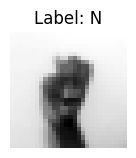

In [ ]:
# Example usage
image_path = '/content/gdrive/MyDrive/AI/asl_imgs/N.jpeg'
image = load_image(image_path)
# converting PIL image to NumPy array
image_array = np.array(image)
# squeezing singleton dimensions if present
image_array = np.squeeze(image_array)
prediction = predict(model, image)
print(f'Predicted class: {alph_dict[prediction]}')
plot_image(image,alph_dict[prediction] )

Predicted class: V


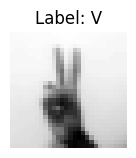

In [ ]:
# Example usage
image_path = '/content/gdrive/MyDrive/AI/asl_imgs/V.jpeg'
image = load_image(image_path)
# converting PIL image to NumPy array
image_array = np.array(image)
# squeezing singleton dimensions if present
image_array = np.squeeze(image_array)
prediction = predict(model, image)
print(f'Predicted class: {alph_dict[prediction]}')
plot_image(image,alph_dict[prediction] )

Predicted class: W


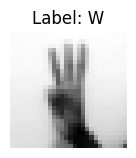

In [ ]:
# Example usage
image_path = '/content/gdrive/MyDrive/AI/asl_imgs/W.jpeg'
image = load_image(image_path)
# converting PIL image to NumPy array
image_array = np.array(image)
# squeezing singleton dimensions if present
image_array = np.squeeze(image_array)
prediction = predict(model, image)
print(f'Predicted class: {alph_dict[prediction]}')
plot_image(image,alph_dict[prediction] )

Predicted class: L


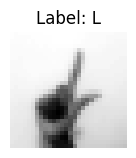

In [ ]:
# Example usage
image_path = '/content/gdrive/MyDrive/AI/asl_imgs/L.jpeg'
image = load_image(image_path)
# converting PIL image to NumPy array
image_array = np.array(image)
# squeezing singleton dimensions if present
image_array = np.squeeze(image_array)
prediction = predict(model, image)
print(f'Predicted class: {alph_dict[prediction]}')
plot_image(image,alph_dict[prediction] )

Predicted class: Y


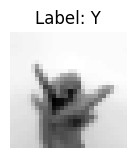

In [ ]:
# Example usage
image_path = 'Y.jpeg'
image = load_image(image_path)
# converting PIL image to NumPy array
image_array = np.array(image)
# squeezing singleton dimensions if present
image_array = np.squeeze(image_array)
prediction = predict(model, image)
print(f'Predicted class: {alph_dict[prediction]}')
plot_image(image,alph_dict[prediction] )

Predicted class: O


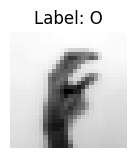

In [ ]:
# Example usage
image_path = '/content/gdrive/MyDrive/AI/asl_imgs/C.jpeg'
image = load_image(image_path)
# converting PIL image to NumPy array
image_array = np.array(image)
# squeezing singleton dimensions if present
image_array = np.squeeze(image_array)
prediction = predict(model, image)
print(f'Predicted class: {alph_dict[prediction]}')
plot_image(image,alph_dict[prediction] )

# Saving the Model

In [ ]:
# import pickle
# pickle.dump(model, open('/content/drive/MyDrive/AI/model_cnn.pkl', 'wb'))
# model = pickle.load(open('/content/drive/MyDrive/AI/model_cnn.pkl', 'rb'))